In [1]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import cell2location
from matplotlib import rcParams
from cell2location.utils.filtering import filter_genes

from cell2location.models import RegressionModel

rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

results_folder = 'cell2location/results/lymph_nodes_analysis/'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

In [3]:
import os
print(os.environ.get("CUDA_VISIBLE_DEVICES"))

None


In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch
torch.set_float32_matmul_precision('high')  # Ou 'high' se quiser mais desempenho

In [5]:
import torch
print(torch.cuda.is_available())  # Deve retornar True
print(torch.cuda.device_count())  # Número de GPUs disponíveis
print(torch.cuda.get_device_name(0))  # Nome da GPU em uso
print(torch.cuda.current_device())  # ID da GPU atual

False
0


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│   1 import torch                                                                                 │
│   2 print(torch.cuda.is_available())  # Deve retornar True                                       │
│   3 print(torch.cuda.device_count())  # Número de GPUs disponíveis                               │
│ ❱ 4 print(torch.cuda.get_device_name(0))  # Nome da GPU em uso                                   │
│   5 print(torch.cuda.current_device())  # ID da GPU atual                                        │
│   6                                                                                              │
│                                                                                                  │
│ /Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-project-McUDH8AL-py3.13/lib/p │
│ ython3.13/site-packages/torch/cuda/__init__.py:491 in get_device_name                            │
│                                                                                                  │
│    488 │   Returns:                                                                              │
│    489 │   │   str: the name of the device                                                       │
│    490 │   """                                                                                   │
│ ❱  491 │   return get_device_properties(device).name                                             │
│    492                                                                                           │
│    493                                                                                           │
│    494 def get_device_capability(device: Optional[_device_t] = None) -> Tuple[int, int]:         │
│                                                                                                  │
│ /Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-project-McUDH8AL-py3.13/lib/p │
│ ython3.13/site-packages/torch/cuda/__init__.py:523 in get_device_properties                      │
│                                                                                                  │
│    520 │   Returns:                                                                              │
│    521 │   │   _CudaDeviceProperties: the properties of the device                               │
│    522 │   """                                                                                   │
│ ❱  523 │   _lazy_init()  # will define _get_device_properties                                    │
│    524 │   device = _get_device_index(device, optional=True)                                     │
│    525 │   if device < 0 or device >= device_count():                                            │
│    526 │   │   raise AssertionError("Invalid device id")                                         │
│                                                                                                  │
│ /Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-project-McUDH8AL-py3.13/lib/p │
│ ython3.13/site-packages/torch/cuda/__init__.py:310 in _lazy_init                                 │
│                                                                                                  │
│    307 │   │   │   │   "multiprocessing, you must use the 'spawn' start method"                  │
│    308 │   │   │   )                                                                             │
│    309 │   │   if not hasattr(torch._C, "_cuda_getDeviceCount"):                                 │
│ ❱  310 │   │   │   raise AssertionError("Torch not compiled with CUDA enabled")                  │
│    311 │   │   if _cudart is None:                         


Published scRNA-seq datasets of lymph nodes have typically lacked an adequate representation of germinal centre-associated immune cell populations due to age of patient donors. We, therefore, include scRNA-seq datasets spanning lymph nodes, spleen and tonsils in our single-cell reference to ensure that we captured the full diversity of immune cell states likely to exist in the spatial transcriptomic dataset.

Here we download this dataset, import into anndata and change variable names to ENSEMBL gene identifiers.

Note!

Before we estimate the reference cell type signature we recommend to perform very permissive genes selection. We prefer this to standard highly-variable-gene selection because our procedure keeps markers of rare genes while removing most of the uninformative genes.

The default parameters cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12 are a good starting point, however, you can increase the cut-off to exclude more genes. To preserve marker genes of rare cell types we recommend low cell_count_cutoff=5, however, cell_percentage_cutoff2 and nonz_mean_cutoff can be increased to select between 8k-16k genes.

In this 2D histogram, orange rectangle highlights genes excluded based on the combination of number of cells expressing that gene (Y-axis) and average RNA count for cells where the gene was detected (X-axis).

In this case, the downloaded dataset was already filtered using this method, hence no density under the orange rectangle (to be changed in the future version of the tutorial).



In [6]:
# Read data
adata_ref = sc.read(
    f'./data/sc.h5ad',
    backup_url='https://cell2location.cog.sanger.ac.uk/paper/integrated_lymphoid_organ_scrna/RegressionNBV4Torch_57covariates_73260cells_10237genes/sc.h5ad'
)

In [7]:
inca_atlas = catalog.load('multi_tissue_tumor_microenvironment_atlas')

[03/10/25 19:05:23] INFO     Loading data from multi_tissue_tumor_microenvironment_atlas        ]8;id=521110;file:///Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-project-McUDH8AL-py3.13/lib/python3.13/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=574513;file:///Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-project-McUDH8AL-py3.13/lib/python3.13/site-packages/kedro/io/data_catalog.py#390\390]8;;\
                             (AnnDataset)...                                                                       

In [23]:
inca_atlas.obs["batch"].unique()


[0, 1, 7, 6, 3, 8, 5, 2, 4]
Categories (9, int64): [0, 1, 2, 3, ..., 5, 6, 7, 8]

In [24]:
inca_atlas.obs["X_scvi_batch"].unique()


array([ 65,  61,  68,  59,  58,  43,  44,  46,  17, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 147, 143, 146, 145, 148, 144,  23,  25,
        18,  27,  24,  20,  28,  21,  22,  19,  26,  29,  30,  36,  35,
        34,  33,  32,  31,  86,  81,  82,  83,  84,  85,  80,  67,  64,
        54,  57,  55,  56,  70,  74,  73,  71,  72,  79,  77,  75,  76,
        78,  95,  11,  12,  13,  14,  15,  87,  88,  89,  90, 102, 103,
       107, 105,  98,  91,  92,  93,  94,   8,   1,  10,   7,   4,   5,
         3,  60,  62,  69,  66,  63, 100,  96,  39,  38,  45,  50,  41,
        42,  48,  49,  37,  40,  47,  52,  51,  53,  97,  99, 106, 101,
       104,   6,   0,   9,   2,  16])

In [18]:
inca_atlas.layers["raw_expression"] = inca_atlas.raw.X.copy()
inca_atlas.layers["counts"] = inca_atlas.raw.X.astype(np.int32)

In [20]:
from hexcore_project.pipelines import utils


In [21]:
adata_ref.shape

(73260, 10237)

In [10]:
inca_atlas.raw.X = inca_atlas.raw.X.astype(np.int32)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 inca_atlas.raw.X = inca_atlas.raw.X.astype(np.int32)                                         │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: property 'X' of 'Raw' object has no setter

In [ ]:
print(inca_atlas.X[:5, :5]) 
print("Valores inteiros?", (inca_atlas.X.astype(int) == inca_atlas.X).all())

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 7 stored elements and shape (5, 5)>
  Coords	Values
  (0, 0)	1.1916551619086884
  (0, 2)	1.4903817145184424
  (0, 3)	0.7637282750984414
  (2, 2)	1.3041521355640715
  (4, 0)	0.700349182755505
  (4, 2)	0.4102722014890335
  (4, 3)	0.4102722014890335


[03/10/25 18:54:39] WARNING  /Users/victor.apolonio/Library/Caches/pypoetry/virtualenvs/hexcore-pro ]8;id=842853;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py\warnings.py]8;;\:]8;id=953325;file:///opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/warnings.py#110\110]8;;\
                             ject-McUDH8AL-py3.13/lib/python3.13/site-packages/IPython/core/interac                
                             tiveshell.py:3579: SparseEfficiencyWarning: Comparing sparse matrices                 
                             using == is inefficient, try using != instead.                                        
                               exec(code_obj, self.user_global_ns, self.user_ns)                                   
                                                                                                                   

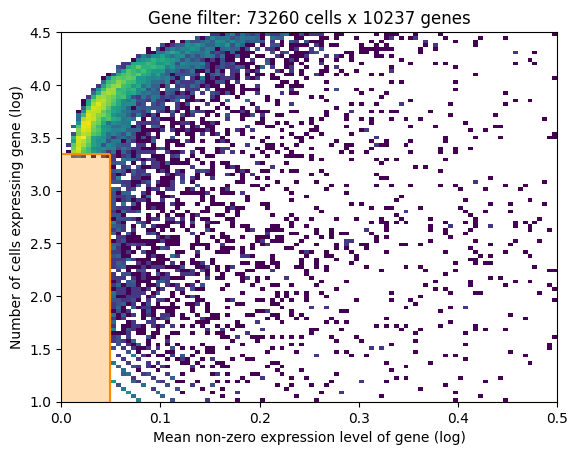

In [8]:


adata_ref.var['SYMBOL'] = adata_ref.var.index
# rename 'GeneID-2' as necessary for your data
adata_ref.var.set_index('GeneID-2', drop=True, inplace=True)

# delete unnecessary raw slot (to be removed in a future version of the tutorial)
del adata_ref.raw

selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()

In [22]:
# prepare anndata for the regression model
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
    # 10X reaction / sample / batch
    batch_key='Sample',
    # cell type, covariate used for constructing signatures
    labels_key='Subset',
    # multiplicative technical effects (platform, 3' vs 5', donor effect)
    categorical_covariate_keys=['Method']
   )

In [2]:
help(RegressionModel)

Help on class RegressionModel in module cell2location.models.reference._reference_model:

class RegressionModel(cell2location.models.base._pyro_mixin.QuantileMixin, scvi.model.base._pyromixin.PyroSampleMixin, scvi.model.base._pyromixin.PyroSviTrainMixin, cell2location.models.base._pyro_mixin.PltExportMixin, scvi.model.base._base_model.BaseModelClass)
 |  RegressionModel(
 |      adata: anndata._core.anndata.AnnData,
 |      model_class=None,
 |      use_average_as_initial: bool = True,
 |      **model_kwargs
 |  )
 |
 |  Model which estimates per cluster average mRNA count account for batch effects. User-end model class.
 |
 |  https://github.com/BayraktarLab/cell2location
 |
 |  Parameters
 |  ----------
 |  adata
 |      single-cell AnnData object that has been registered via :func:`~scvi.data.setup_anndata`.
 |  use_gpu
 |      Use the GPU?
 |  **model_kwargs
 |      Keyword args for :class:`~scvi.external.LocationModelLinearDependentWMultiExperimentModel`
 |
 |  Examples
 |  ------

In [23]:
# create the regression model
scrna_signature_model = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
scrna_signature_model.view_anndata_setup()

Anndata setup with scvi-tools version 1.2.2.post2.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'Sample',
│   'labels_key': 'Subset',
│   'categorical_covariate_keys': ['Method'],
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  23   │
│         n_cells          │ 73260 │
│ n_extra_categorical_covs │   1   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │  34   │
│          n_vars          │ 10237 │
└──────────────────────────┴───────┘

                             Data Registry                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃            scvi-tools Location             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │                  adata.X                   │
│         batch          │          adata.obs['_scvi_batch']          │
│ extra_categorical_covs │ adata.obsm['_scvi_extra_categorical_covs'] │
│         ind_x          │           adata.obs['_indices']            │
│         labels         │         adata.obs['_scvi_labels']          │
└────────────────────────┴────────────────────────────────────────────┘

                         batch State Registry                         
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃       Categories       ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Sample'] │    4861STDY7135913     │          0          │
│                     │    4861STDY7135914     │          1          │
│                     │    4861STDY7208412     │          2          │
│                     │    4861STDY7208413     │          3          │
│                     │    4861STDY7462253     │          4          │
│                     │    4861STDY7462254     │          5          │
│                     │    4861STDY7462255     │          6          │
│                     │    4861STDY7462256     │          7          │
│                     │    4861STDY7528597     │          8          │
│                     │    4861STDY7528598     │          9          │
│                     │    4861STDY7528599     │         10          │
│                     │    4861STDY7528600     │         11          │
│                     │      BCP002_Total      │         12          │
│                     │      BCP003_Total      │         13          │
│                     │      BCP004_Total      │         14          │
│                     │      BCP005_Total      │         15          │
│                     │      BCP006_Total      │         16          │
│                     │      BCP008_Total      │         17          │
│                     │      BCP009_Total      │         18          │
│                     │ Human_colon_16S7255677 │         19          │
│                     │ Human_colon_16S7255678 │         20          │
│                     │ Human_colon_16S8000484 │         21          │
│                     │      Pan_T7935494      │         22          │
└─────────────────────┴────────────────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Subset'] │    B_Cycling     │          0          │
│                     │     B_GC_DZ      │          1          │
│                     │     B_GC_LZ      │          2          │
│                     │    B_GC_prePB    │          3          │
│                     │      B_IFN       │          4          │
│                     │   B_activated    │          5          │
│                     │      B_mem       │          6          │
│                     │     B_naive      │          7          │
│                     │     B_plasma     │          8          │
│                     │     B_preGC      │          9          │
│                     │     DC_CCR7+     │         10          │
│                     │     DC_cDC1      │         11          │
│                     │     DC_cDC2      │         12          │
│                     │      DC_pDC      │         13          │
│                     │       Endo       │         14          │
│                     │       FDC        │         15          │
│                     │       ILC        │         16          │
│                     │  Macrophages_M1  │         17          │
│                     │  Macrophages_M2  │         18          │
│                     │       Mast       │         19          │
│                     │    Monocytes     │         20          │
│                     │        NK        │         21          │
│                     │       NKT        │         22          │
│                     │      T_CD4+      │         23          │
│                     │    T_CD4+_TfH    │         24          │
│                     │  T_CD4+_TfH_GC   │         25          │
│                     │   T_CD4+_naive   │         26          │
│                     │  T_CD8+_CD161+   │         27          │
│                     │ T_CD8+_cytotoxic │         28          │
│                     │   T_CD8+_naive   │         29          │
│                     │     T_TIM3+      │         30          │
│                     │      T_TfR       │         31          │
│                     │      T_Treg      │         32          │
│                     │       VSMC       │         33          │
└─────────────────────┴──────────────────┴─────────────────────┘

          extra_categorical_covs State Registry           
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Method'] │    3GEX    │          0          │
│                     │    5GEX    │          1          │
│                     │            │                     │
└─────────────────────┴────────────┴─────────────────────┘

In [24]:
# Treinamento
scrna_signature_model.train(max_epochs=300)

INFO: GPU available: True (cuda), used: True


[03/08/25 19:30:08] INFO     GPU available: True (cuda), used: True                                 ]8;id=295608;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=666897;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: TPU available: False, using: 0 TPU cores


                    INFO     TPU available: False, using: 0 TPU cores                               ]8;id=214311;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=606787;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

INFO: HPU available: False, using: 0 HPUs


                    INFO     HPU available: False, using: 0 HPUs                                    ]8;id=117568;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=379709;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

                    WARNING  /storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-projec ]8;id=282198;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py\warnings.py]8;;\:]8;id=129095;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py#112\112]8;;\
                             t-env/lib/python3.12/site-packages/lightning/pytorch/trainer/configura                
                             tion_validator.py:68: You passed in a `val_dataloader` but have no                    
                             `validation_step`. Skipping val loop.                                                 
                                                                                                                   

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


                    INFO     LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]                                   ]8;id=910133;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning/pytorch/accelerators/cuda.py\cuda.py]8;;\:]8;id=708153;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning/pytorch/accelerators/cuda.py#61\61]8;;\

                    WARNING  /storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-projec ]8;id=279486;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py\warnings.py]8;;\:]8;id=697692;file:///home/biosis-gpu/anaconda3/lib/python3.12/warnings.py#112\112]8;;\
                             t-env/lib/python3.12/site-packages/lightning/pytorch/trainer/connector                
                             s/data_connector.py:425: The 'train_dataloader' does not have many                    
                             workers which may be a bottleneck. Consider increasing the value of                   
                             the `num_workers` argument` to `num_workers=31` in the `DataLoader` to                
                             improve performance.                                                                  
                                                                                                                   

Training:   0%|          | 0/300 [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=300` reached.


[03/08/25 19:51:43] INFO     `Trainer.fit` stopped: `max_epochs=300` reached.                       ]8;id=261860;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=250411;file:///storage-a/users_data/jupyter/vapolonio/hexcore-project/hexcore-project-env/lib/python3.12/site-packages/lightning_utilities/core/rank_zero.py#63\63]8;;\

Determine if the model needs more training.

Here, we plot ELBO loss history during training, removing first 20 epochs from the plot. This plot should have a decreasing trend and level off by the end of training. If it is still decreasing, increase max_epochs.

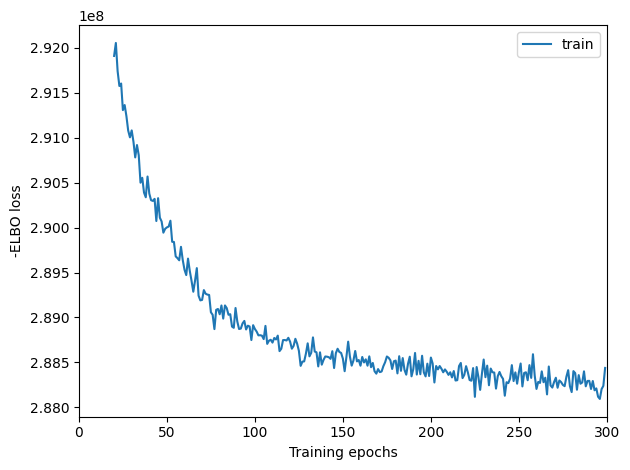

In [25]:
scrna_signature_model.plot_history(20)

In [26]:

# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = scrna_signature_model.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 2000, 'batch_size': 2500}
)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)

Sampling local variables, batch:   0%|          | 0/30 [00:00<?, ?it/s]

Sampling global variables, sample:   0%|          | 0/1999 [00:00<?, ?it/s]

In [27]:

# Save model
scrna_signature_model.save(f"{ref_run_name}", overwrite=True)


In [28]:
scrna_signature_model

RegressionBackgroundDetectionTech model with the following params: 
n_factors: 34 
n_batch: 23 
Training status: Trained
<class 'cell2location.models.reference._reference_model.RegressionModel'>.__repr__ returned empty string